# Time series prediction

This notebook is largely inspired by Laurence Moroney's [Coursera tutorial](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction) about time series prediction. The goal is to compare models for predicting daily temperatures in New York City, from the simplest methods up to TensorFlow neural networks. We use 10 years of historical data, available on BigQuery public datasets.

## Setup and data loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

# Settings
sns.set(rc={'figure.figsize':(10,6)})

In [2]:
%%bigquery df
# Get 10 years of NYC daily temperatures
SELECT DISTINCT
    PARSE_DATE("%Y%m%d", CONCAT(year, mo, da)) AS date,
    ROUND((temp - 32) * 5/9, 1) AS temp
FROM `bigquery-public-data.noaa_gsod.gsod*` 
WHERE 
    wban = '94728'
    AND _TABLE_SUFFIX BETWEEN '2010' AND '2019'
ORDER BY date

In [3]:
# Prepare dataframe
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df

,index,date,temp
0,0,2010-01-01,2.2
1,1,2010-01-02,-1.8
2,2,2010-01-03,-7.3
3,3,2010-01-04,-5.0
4,4,2010-01-05,-4.2
...,...,...,...
3647,3647,2019-12-27,9.7
3648,3648,2019-12-28,8.9
3649,3649,2019-12-29,5.9
3650,3650,2019-12-30,4.1


## Prepare train, validation and test sets

We have 10 years of daily temperature data. The first 8 years (2010 to 2017) will be used as training set, while 2018 will be the validation set, and 2019 the test set. 
For time series, it would inappropriate to select rows at random for the training/validation/test sets, as the order of observations should be kept. 

In [65]:
# Helper function for plotting series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
# Helper function for MSE and MAE
def mse_mae(x_valid, x_pred, name=None):
    return pd.Series(data=[keras.metrics.mean_squared_error(x_valid, x_pred).numpy().round(2),
                           keras.metrics.mean_absolute_error(x_valid, x_pred).numpy().round(2)], 
                     index=['MSE', 'MAE'],
                     name=name)

In [5]:
# Create simple lists from 2010-01-01
time = df.loc[df['date'] >= '2010-01-01', 'index'].to_numpy()
series = df.loc[df['date'] >= '2010-01-01', 'temp'].to_numpy()

# Split between training, validation and test sets
valid_start = int(df.loc[df['date'] == '2018-01-01', 'index'])
test_start = int(df.loc[df['date'] == '2019-01-01', 'index'])

time_train = time[:valid_start]
x_train = series[:valid_start]
time_valid = time[valid_start:test_start]
x_valid = series[valid_start:test_start]
time_test = time[test_start:]
x_test = series[test_start:]

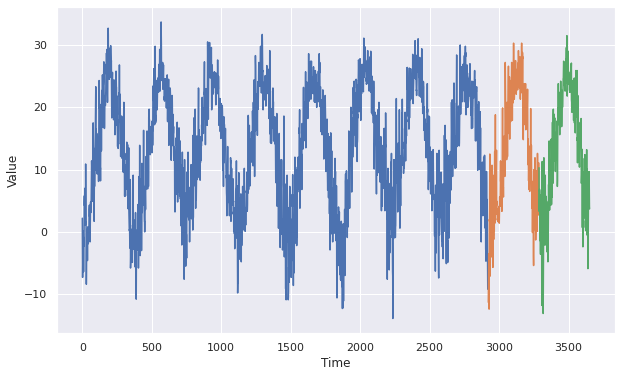

In [6]:
# Plot training set
plot_series(time_train, x_train)

# Plot validation test
plot_series(time_valid, x_valid)

# Plot test set
plot_series(time_test, x_test)

## Simple forecasts

### Naive forecast

A performance baseline can be established with an very basic model: predict each day temperature with the previous day value.

In [7]:
# Naive forecast is just day N-1
naive_forecast = series[valid_start-1:test_start-1]

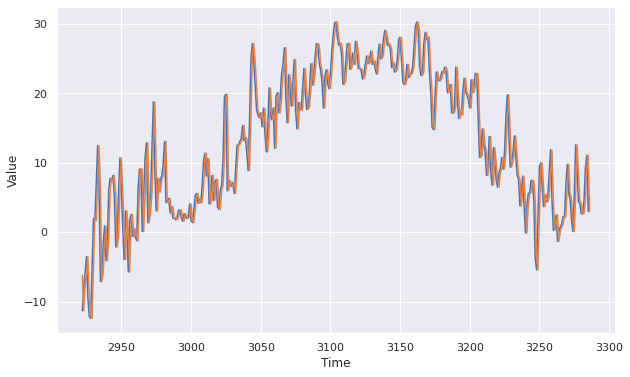

In [8]:
# Plot result
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

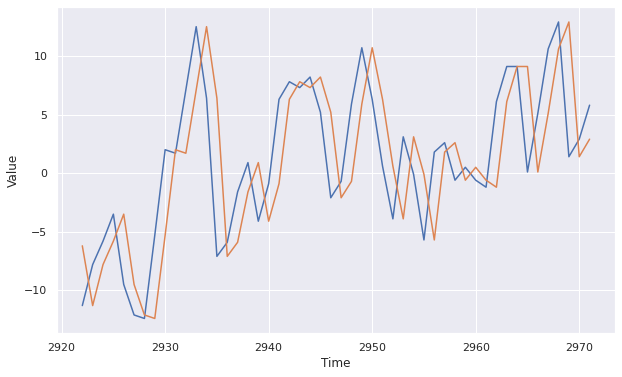

In [9]:
# Zoom on 100 days
plot_series(time_valid[:50], x_valid[:50])
plot_series(time_valid[:50], naive_forecast[:50])

In [68]:
# Performance
naive_forecast_perfs = mse_mae(x_valid, naive_forecast, name='Naive Forecast')
naive_forecast_perfs

MSE    12.01
MAE     2.61
Name: Naive Forecast, dtype: float64

### Moving average

Let's compare our baseline model with a simple 30-day moving average.

In [11]:
# Helper function to calculate moving average
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

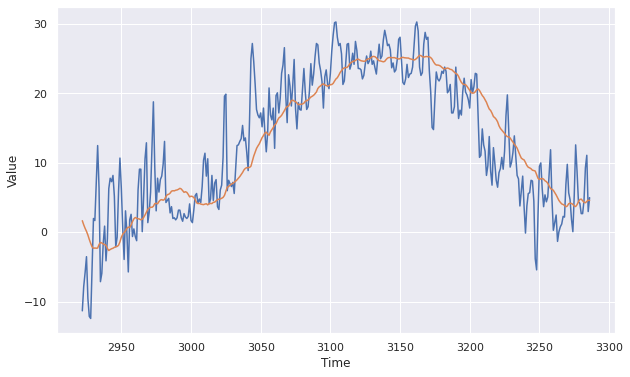

In [12]:
# Moving average over 30 days
moving_avg = moving_average_forecast(series, 30)[valid_start - 30:test_start-30]

# Plot result
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [69]:
# Performance
moving_avg_perfs = mse_mae(x_valid, moving_avg, name="Moving average")
moving_avg_perfs

MSE    23.92
MAE     3.73
Name: Moving average, dtype: float64

The performance is not nearly as good as the benchmark, the MSE is almost twice as high. The model gets the general trend, but completely misses the daily variations, and has a 30-day lag in seasonality.

### Differentiated moving average

Moving average does not help to predict future values. For seasonal time series like temperatures, values of the previous year may be useful. One strategy is to try to predict the difference between day D and D-365. We then add the seasonality, and see if the prediction is better.

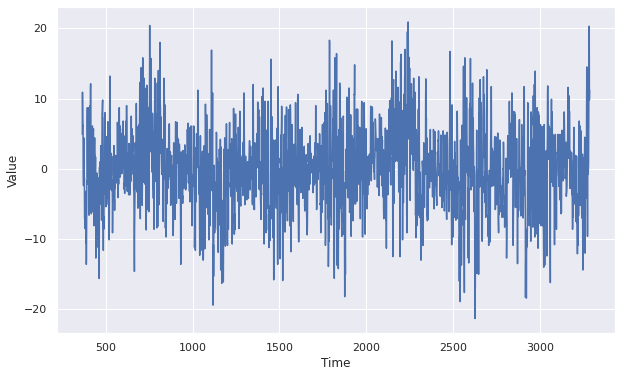

In [14]:
# Remove seasonality by substracting N-365 days 
diff_series = (series[365:test_start] - series[:test_start-365])
diff_time = time[365:test_start]

plot_series(diff_time, diff_series)

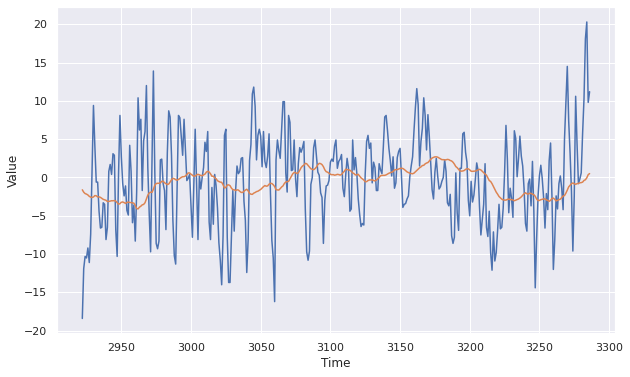

In [15]:
# Differentiated moving average is the moving average with N-365 value substracted
diff_moving_avg = moving_average_forecast(diff_series, 50)[valid_start - 365 - 50:test_start]

plot_series(time_valid, diff_series[valid_start - 365:test_start])
plot_series(time_valid, diff_moving_avg)

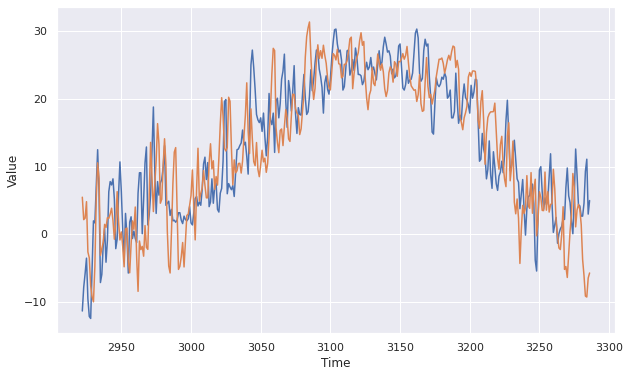

In [16]:
# Need to add past value for actual forecast
diff_moving_avg_plus_past = series[valid_start - 365:test_start - 365] + diff_moving_avg

plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

In [74]:
# Performance
diff_moving_avg_plus_past_perfs = mse_mae(x_valid, diff_moving_avg_plus_past, name="Differentiated moving average")
diff_moving_avg_plus_past_perfs

MSE    35.80
MAE     4.71
Name: Differentiated moving average, dtype: float64

The performance of the differentiated moving average is significantly worse than the simple moving average, so this strategy does not work here.

### Smoothed differentiated average

To remove the noise of the previous method, the differentiated moving average, we can substract the *moving average* for the previous year, instead of the daily values. 

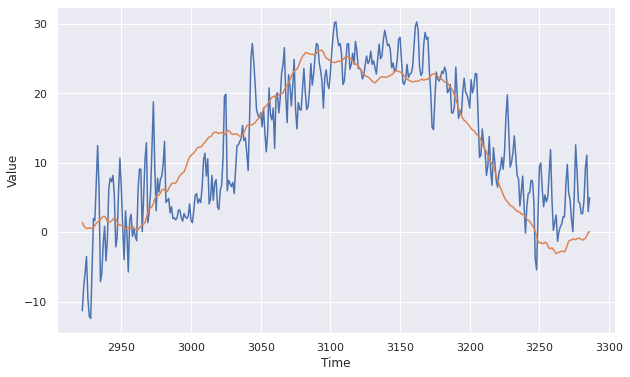

In [18]:
# To smoothen the predictions, substract moving average from N-365 days
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[valid_start - 370:test_start - 320], 50) + diff_moving_avg

plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)

In [81]:
# Performance
diff_moving_avg_plus_smooth_past_perfs = mse_mae(x_valid, diff_moving_avg_plus_smooth_past, 
                                                 name="Smoothed diff. moving average")
diff_moving_avg_plus_smooth_past_perfs

MSE    29.26
MAE     4.37
Name: Smoothed diff. moving average, dtype: float64

This enhances the prediction performance, that is more similar to 30-day moving average model.

## Deep Neural Networks

The first neural network with TensorFlow is a relatively simple DNN model, with three sequential layers.

In [20]:
# Helper function to prepare dataset for batches
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Prepare dataset
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

### Find optimal learning rate

In [21]:
# Search for optimal learning rate
tf.keras.backend.clear_session()
dnn_grid_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

dnn_grid_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
dnn_grid_history = dnn_grid_model.fit(dataset, epochs=200, callbacks=[lr_schedule], verbose=0)

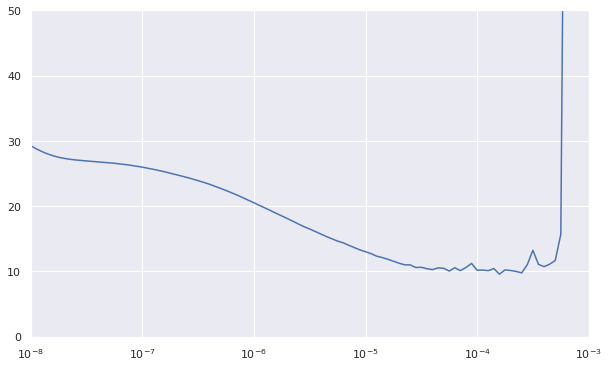

In [22]:
# Plot loss vs learning rate
lrs = 1e-8 * (10 ** (np.arange(200) / 20))
plt.semilogx(lrs, dnn_grid_history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 50]);

### Train model with optimal learning rate

In [23]:
# Retrain using best learning rate (ie 10e-4)
tf.keras.backend.clear_session()
dnn_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

dnn_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9))
dnn_history = dnn_model.fit(dataset, epochs=150, verbose=0)

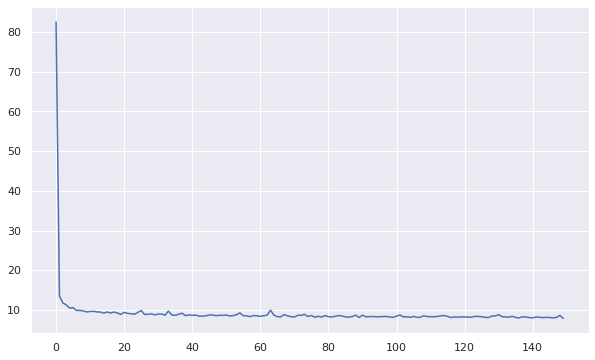

In [24]:
# Look at training loss vs epochs
loss = dnn_history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss');

In [25]:
# Predict on validation set
dnn_forecast = []
for time in range(valid_start-window_size, test_start-window_size):
    dnn_forecast.append(dnn_model.predict(series[time:time + window_size][np.newaxis]))

dnn_results = np.array(dnn_forecast)[:, 0, 0]

In [27]:
# Performance on validation set
mse_mae(x_valid, dnn_results)

MSE: 10.7
MAE: 2.5


### Evaluate on test set

In [28]:
# Predict on test set
dnn_test_forecast = []
for time in range(test_start-window_size, len(series)-window_size):
    dnn_test_forecast.append(dnn_model.predict(series[time:time + window_size][np.newaxis]))

dnn_test_results = np.array(dnn_test_forecast)[:, 0, 0]

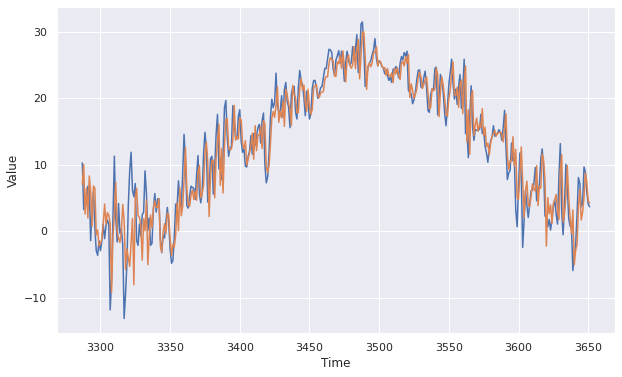

In [29]:
# Plot results
plot_series(time_test, x_test)
plot_series(time_test, dnn_test_results)

In [76]:
# Performance on test set
dnn_perfs = mse_mae(x_test, dnn_test_results, name="DNN")
dnn_perfs

MSE    11.65
MAE     2.43
Name: DNN, dtype: float64

This starts well ! This first DNN model performs better than the naive forecast.

## Recurrent Neural Network

RNN use "recurring" layers, that can perform well on time series predictions.

### Find optimal learning rate

In [31]:
# Build model
tf.keras.backend.clear_session()
rnn_grid_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [32]:
# Search for optimal learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
rnn_grid_model.compile(loss=tf.keras.losses.Huber(),
                       optimizer=optimizer,
                       metrics=["mae"])

rnn_grid_history = rnn_grid_model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

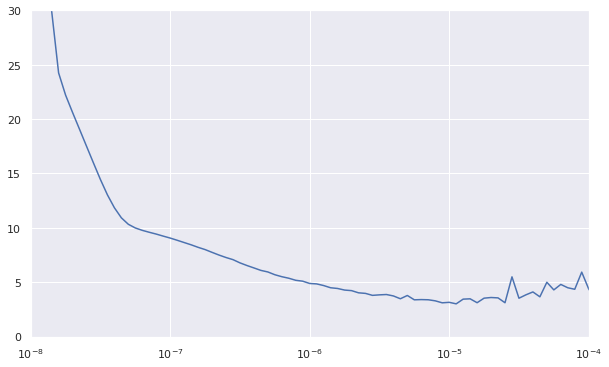

In [33]:
# Plot losses
plt.semilogx(rnn_grid_history.history["lr"], rnn_grid_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30]);

### Train model with optimal learning rate

In [34]:
# Build optimal model
tf.keras.backend.clear_session()
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Train model
rnn_model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),
                  metrics=["mae"])
rnn_history = rnn_model.fit(dataset, epochs=200, verbose=0)

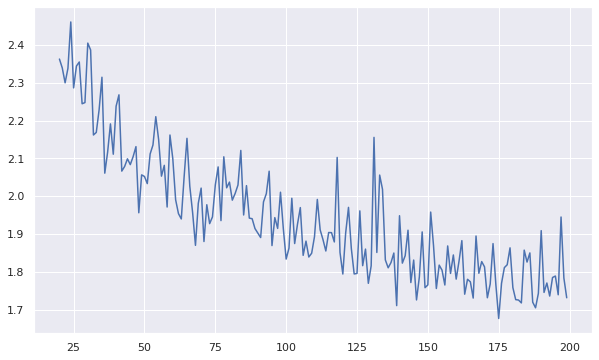

In [35]:
# Look at training loss vs epochs
loss = rnn_history.history['loss']
epochs = range(20, len(loss))
plt.plot(epochs, loss[20:], 'b', label='Training Loss');

In [36]:
# Predict on validation set
rnn_forecast = []
for time in range(valid_start-window_size, test_start-window_size):
    rnn_forecast.append(rnn_model.predict(series[time:time + window_size][np.newaxis]))

rnn_results = np.array(rnn_forecast)[:, 0, 0]

In [38]:
# Performance
mse_mae(x_valid, rnn_results)

MSE: 15.76
MAE: 2.93


### Evaluate on test set

In [39]:
# Predict on test set
rnn_test_forecast = []
for time in range(test_start-window_size, len(series)-window_size):
    rnn_test_forecast.append(rnn_model.predict(series[time:time + window_size][np.newaxis]))

rnn_test_results = np.array(rnn_test_forecast)[:, 0, 0]

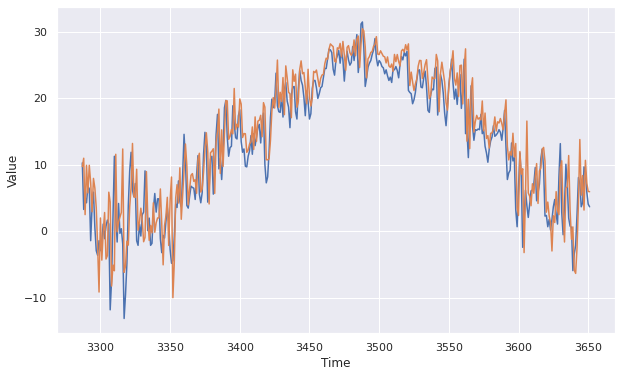

In [40]:
# Plot results
plot_series(time_test, x_test)
plot_series(time_test, rnn_test_results)

In [77]:
# Performance on test set
rnn_perfs = mse_mae(x_test, rnn_test_results, name="RNN")
rnn_perfs

MSE    16.01
MAE     2.99
Name: RNN, dtype: float64

This RNN actually performs significantly worse than the simple DNN, and does not over-perform the naive benchmark.


## LSTM model

The model can be sophisticated with a Long Short-Term Memory layer with 32 cells.

### Find optimal learning rate

In [42]:
# Build model
tf.keras.backend.clear_session()
lstm_grid_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [43]:
# Search for optimal learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

lstm_grid_model.compile(loss=tf.keras.losses.Huber(),
                        optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),
                        metrics=["mae"])

lstm_grid_history = lstm_grid_model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

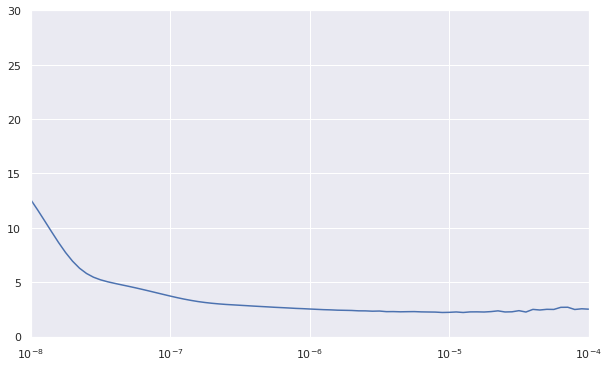

In [44]:
### Plot losses
plt.semilogx(lstm_grid_history.history["lr"], lstm_grid_history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30]);

### Train model with optimal learning rate

In [45]:
### Build optimized model
tf.keras.backend.clear_session()
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

### Train model
lstm_model.compile(loss=tf.keras.losses.Huber(),
                   optimizer=tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9),
                   metrics=["mae"])

lstm_history = lstm_model.fit(dataset, epochs=200, verbose=0)

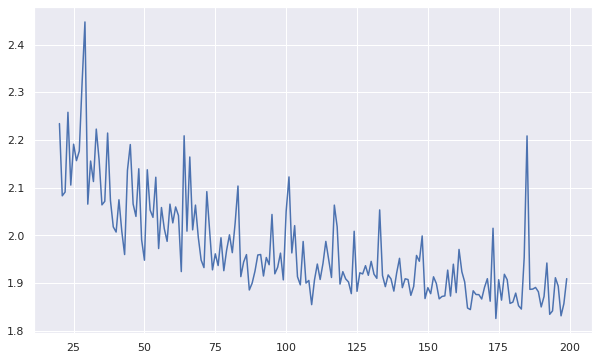

In [46]:
# Look at training loss vs epochs
loss = lstm_history.history['loss']
epochs = range(20, len(loss))
plt.plot(epochs, loss[20:], 'b', label='Training Loss');

In [47]:
# Predict on validation set
lstm_forecast = []
for time in range(valid_start-window_size, test_start-window_size):
    lstm_forecast.append(lstm_model.predict(series[time:time + window_size][np.newaxis]))

lstm_results = np.array(lstm_forecast)[:, 0, 0]

In [49]:
# Performance
mse_mae(x_valid, lstm_results)

MSE: 10.41
MAE: 2.5


### Evaluate on test set

In [50]:
# Predict on test set
lstm_test_forecast = []
for time in range(test_start-window_size, len(series)-window_size):
    lstm_test_forecast.append(lstm_model.predict(series[time:time + window_size][np.newaxis]))

lstm_test_results = np.array(lstm_test_forecast)[:, 0, 0]

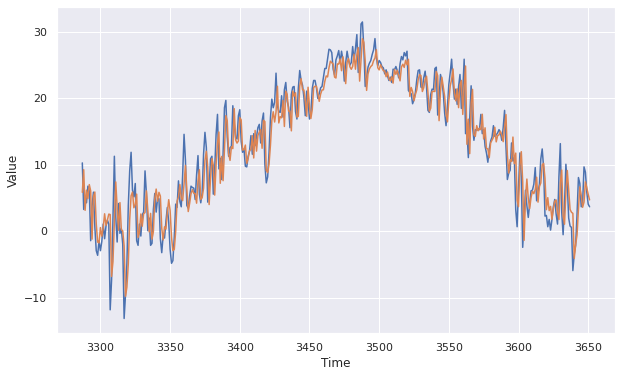

In [51]:
# Plot results
plot_series(time_test, x_test)
plot_series(time_test, lstm_test_results)

In [78]:
# Performance on test set
lstm_perfs = mse_mae(x_test, lstm_test_results, name="LSTM")
lstm_perfs

MSE    9.96
MAE    2.37
Name: LSTM, dtype: float64

This last model is the best performer, with an MSE well under our forecast. Looking at the predictions on the graph is quite fascinating, some daily variations seem to be predicted with magic!

## Compare results

In [83]:
# Sort models by MSE
pd.DataFrame([
    naive_forecast_perfs,
    moving_avg_perfs,
    diff_moving_avg_plus_past_perfs,
    diff_moving_avg_plus_smooth_past_perfs,
    dnn_perfs,
    rnn_perfs,
    lstm_perfs
]).sort_values('MSE')

,MSE,MAE
LSTM,9.96,2.37
DNN,11.65,2.43
Naive Forecast,12.01,2.61
RNN,16.01,2.99
Moving average,23.92,3.73
Smoothed diff. moving average,29.26,4.37
Differentiated moving average,35.80,4.71


The naive forecast model, that simply took the previous day as prediction for each day, was surprisingly hard to beat ! Only the DNN and LSTM models could achieve a better performance. 